# Notification Service using Kafka

- Parse content from a salads recipe website
- Create Kafka Producer to log raw markup as raw content
- Create Kafka Consumer to log parsed content as a json dump
- Create Kafka producer to log these parsed dumps 
- Create Kafka consumer that pushes a notification whenever a salad has high calorie content

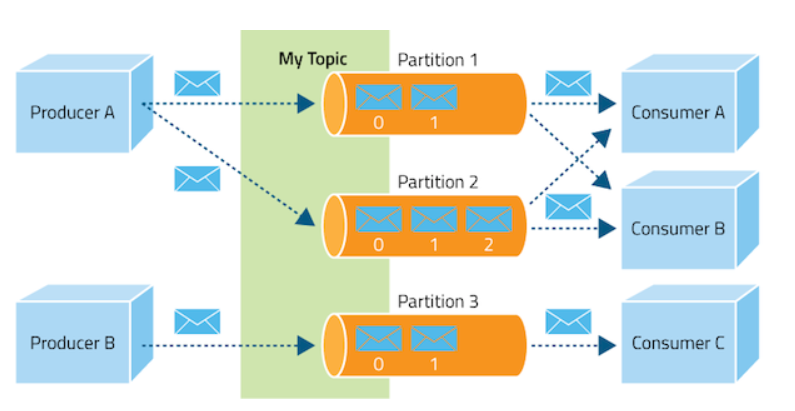

In [10]:
import parser_utils
import kafka_utils

import json
from pprint import pprint

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Creating list of raw markups from recipes
all_recipes = parser_utils.get_recipes()

Fetching Recipe for this link -->  https://www.allrecipes.com/recipe/16409/spinach-and-strawberry-salad/
Fetching Recipe for this link -->  https://www.allrecipes.com/recipe/270850/roasted-beet-salad/
Fetching Recipe for this link -->  https://www.allrecipes.com/recipe/215030/taco-slaw/
Fetching Recipe for this link -->  https://www.allrecipes.com/recipe/254568/all-american-loaded-baked-potato-salad/
Fetching Recipe for this link -->  https://www.allrecipes.com/recipe/270199/freekeh-salad-with-tahini-dressing/
Fetching Recipe for this link -->  https://www.allrecipes.com/recipe/266401/cucumber-chicken-salad-with-spicy-peanut-dressing/
Fetching Recipe for this link -->  https://www.allrecipes.com/recipe/269287/all-kale-caesar/
Fetching Recipe for this link -->  https://www.allrecipes.com/recipe/52734/awesome-pasta-salad/
Fetching Recipe for this link -->  https://www.allrecipes.com/recipe/14403/mediterranean-greek-salad/
Fetching Recipe for this link -->  https://www.allrecipes.com/reci

In [3]:
# Show parsed json object from raw markup
pprint(parser_utils.parse_as_json(all_recipes[0]))

('{"title": "Spinach and Strawberry Salad", "submitter": "JerJer", '
 '"description": "My family loves this all year round if we can find '
 'strawberries. Even the grandchildren love this salad. Quick and easy.", '
 '"calories": "235", "ingredients": ["2 bunches spinach, rinsed and torn into '
 'bite-size pieces", "4 cups sliced strawberries", "1/2 cup vegetable oil", '
 '"1/4 cup white wine vinegar", "1/2 cup white sugar", "1/4 teaspoon paprika", '
 '"2 tablespoons sesame seeds", "1 tablespoon poppy seeds"]}')


## Kafka Producer and Consumer

### CLI output of kafka topics before any topics were created: 
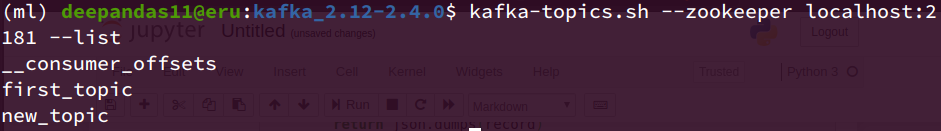

In [4]:
# Publish a message using producer for each recipe

if len(all_recipes) > 0:
    kafka_producer = kafka_utils.connect_kafka_producer()
    for recipe in all_recipes:
        kafka_utils.publish_message(kafka_producer, 'raw_recipes', 'raw', recipe.strip())
    if kafka_producer:
        kafka_producer.close()

Message published successfully!
Message published successfully!
Message published successfully!
Message published successfully!
Message published successfully!
Message published successfully!
Message published successfully!
Message published successfully!
Message published successfully!
Message published successfully!


In [7]:
# Consumer 1 feeds on raw recipes topic and creates parsed_data

parsed_records = [] 

# Two topics 
topic_name = 'raw_recipes'
parsed_topic_name = 'parsed_recipes'

consumer1 = kafka_utils.connect_kafka_consumer(topic_name)

for msg in consumer1:
    html = msg.value
    result = parser_utils.parse_as_json(html)
    parsed_records.append(result)
consumer1.close()

In [8]:
# Producer 2 creates parsed topic and logs parsed data there

if len(parsed_records) > 0:
    print("Publishing Records")
    producer2 = kafka_utils.connect_kafka_producer()
    for rec in parsed_records:
        kafka_utils.publish_message(producer2, parsed_topic_name, 'parsed', rec)

Publishing Records
Message published successfully!
Message published successfully!
Message published successfully!
Message published successfully!
Message published successfully!
Message published successfully!
Message published successfully!
Message published successfully!
Message published successfully!
Message published successfully!


Creation of two new topics:

Notice the two topics added are r

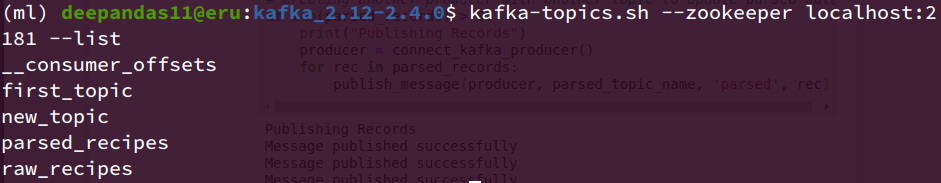

In [11]:
# Consumer 2 feeds on parsed topic and creates notification

calories_threshold = 200
consumer2 = kafka_utils.connect_kafka_consumer(parsed_topic_name)

total_salads = 0
over_salads = 0

for msg in consumer2:
    total_salads += 1
    record = json.loads(msg.value)
    calories = int(record['calories'])
    title = record['title']
    
    if calories > calories_threshold:
        over_salads += 1
        print("Alert! {} Calories count is {}".format(title, calories))
        
if consumer2:
    consumer2.close()
    
print("\nResult: Out of {} Salads, {} were above 200 Calories".format(total_salads, over_salads))

Alert! Spinach and Strawberry Salad Calories count is 235
Alert! Freekeh Salad with Tahini Dressing Calories count is 258
Alert! All Kale Caesar Calories count is 362
Alert! Awesome Pasta Salad Calories count is 310
Alert! Jamie's Cranberry Spinach Salad Calories count is 338

Result: Out of 10 Salads, 5 were above 200 Calories
